# Test for Each LOS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Reshape, Dropout, Attention, Concatenate, LayerNormalization, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from scipy.spatial.distance import cdist

# ---------------------- Model Definition ----------------------

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        return true_positives / (predicted_positives + K.epsilon())

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def build_prediction_model(input_shape, output_steps, n_features):
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)

    attention = Attention()([x, x])  # Self-attention
    x = Concatenate()([x, attention])
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)

    x = GRU(64)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(output_steps * n_features)(x)
    outputs = Reshape((output_steps, n_features))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.00093286), loss='mse', metrics=['mae', f1])
    return model

def load_trained_model(input_shape, output_steps, n_features):
    model = build_prediction_model(input_shape, output_steps, n_features)
    model.load_weights("gru70_epoch_100.weights.h5")
    return model

# ---------------------- Helper Functions ----------------------

def calculate_entropy(data):
    value_counts = np.bincount(data)
    probabilities = value_counts / np.sum(value_counts)
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log2(probabilities))

def dynthreshold(vectime, vecvalue):
    packets_int = np.round(vecvalue).astype(int)
    num_points = len(packets_int)
    window_size = 15
    entropy_values = np.array([
        calculate_entropy(packets_int[max(0, i - window_size):i + 1]) for i in range(num_points)
    ])
    H_avg = np.mean(entropy_values)
    sigma = np.std(entropy_values)
    a = 0.5
    T_1 = H_avg + a * sigma
    return entropy_values, T_1, H_avg

def test_single_sequence(model, input_sequence):
    input_seq = np.expand_dims(input_sequence, axis=0)
    prediction = model.predict(input_seq)[0]
    return prediction

def compute_ewma(series, alpha=0.2):
    ewma = np.zeros_like(series)
    ewma[0] = series[0]
    for t in range(1, len(series)):
        ewma[t] = alpha * series[t] + (1 - alpha) * ewma[t - 1]
    return ewma

# ---------------------- Main Processing ----------------------

if __name__ == "__main__":
    df = pd.read_csv('sequence_data_with_jerk_Attack_70.csv')

    look_back = 10
    look_forward = 5
    n_features = 3
    feature_names = ['Speed', 'Acceleration', 'Jerk']
    target_feature = 'Jerk'

    model = load_trained_model(
        input_shape=(look_back, n_features),
        output_steps=look_forward,
        n_features=n_features
    )

    sequences = df[['LOS', 'DepartureTime', 'Iteration']].drop_duplicates()
    metrics_summary = []

    for idx, row in sequences.iterrows():
        start_time = time.time()

        los = row['LOS']
        departure_time = row['DepartureTime']
        iteration = row['Iteration']
        print(los, departure_time, iteration)
        #seq_df= df[(df['LOS'] == 'E') & (df['DepartureTime'] == 905) & (df['Iteration'] == 17)]
        seq_df = df[(df['LOS'] == los) & (df['DepartureTime'] == departure_time) & (df['Iteration'] == iteration)]
        if len(seq_df) < (look_back + look_forward):
            continue

        time_sequence = seq_df['Time'].values
        full_features = seq_df[['Speed', 'Acceleration', 'Jerk']].values
        full_labels = seq_df['Label'].values.astype(int)

        all_predictions, all_actuals, all_times, all_labels = [], [], [], []

        for i in range(0, len(full_features) - look_back - look_forward + 1, look_forward):
            current_window = full_features[i:i+look_back]
            actual_continuation = full_features[i+look_back:i+look_back+look_forward]
            time_window = time_sequence[i+look_back:i+look_back+look_forward]
            label_window = full_labels[i+look_back:i+look_back+look_forward]
            prediction = test_single_sequence(model, current_window)
            all_predictions.append(prediction)
            all_actuals.append(actual_continuation)
            all_times.append(time_window)
            all_labels.append(label_window)

        if not all_predictions:
            continue

        all_predictions = np.concatenate(all_predictions)
        all_actuals = np.concatenate(all_actuals)
        all_times = np.concatenate(all_times)
        all_labels = np.concatenate(all_labels)

        predicted_sequence = np.vstack([full_features[:look_back], all_predictions])
        actual_sequence = np.vstack([full_features[:look_back], all_actuals])
        time_plot = np.concatenate([time_sequence[:look_back], all_times])
        test_labels = np.concatenate([full_labels[:look_back], all_labels])

        feature_idx = feature_names.index(target_feature)
        window_size = 10
        mse_series = np.array([
            np.mean((actual_sequence[t:t+window_size, feature_idx] - predicted_sequence[t:t+window_size, feature_idx]) ** 2)
            if t + window_size <= len(predicted_sequence) else 0
            for t in range(len(predicted_sequence))
        ])

        # feature_idx = feature_names.index(target_feature)
        # delta = 1.0

        # # Extract the relevant feature from both sequences
        # y_true = actual_sequence[:, feature_idx]
        # y_pred = predicted_sequence[:, feature_idx]

        # # Compute Huber loss for the whole series
        # diff = y_true - y_pred
        # huber_series = np.where(
        #     np.abs(diff) <= delta,
        #     0.5 * diff ** 2,
        #     delta * (np.abs(diff) - 0.5 * delta)
        # )

        smoothed_mse = compute_ewma(mse_series[look_back:])
        entropy_vals, T1, H_avg = dynthreshold(time_plot[look_back:], smoothed_mse)
        anomalies = (entropy_vals > T1).astype(int)

        y_true = test_labels[look_back:look_back+len(smoothed_mse)]
        y_pred = anomalies

        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        FN = np.sum((y_pred == 0) & (y_true == 1))
        TN = np.sum((y_pred == 0) & (y_true == 0))

        try:
            auc = roc_auc_score(y_true, entropy_vals)
        except ValueError:
            auc = np.nan

        f1_val = f1_score(y_true, y_pred, zero_division=0)
        prob_detection = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0.0
        false_alarm_rate = (FP / (FP + TN)) * 100 if (FP + TN) > 0 else 0.0
        anomaly_probability = (np.sum(y_pred == 1) / len(y_pred)) if len(y_pred) > 0 else 0.0

        end_time = time.time()

        metrics_summary.append({
            'LOS': los,
            'DepartureTime': departure_time,
            'Iteration': iteration,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            'PD': prob_detection,
            'FAR': false_alarm_rate,
            'F1': f1_val,
            'AUC': auc,
            'Anomaly_Prob': anomaly_probability,
            'Time_sec': end_time - start_time
        })

        if metrics_summary:
            metrics_df = pd.DataFrame(metrics_summary)
            numeric_cols = metrics_df.select_dtypes(include=np.number).columns
    
            print(f"\n=== Summary Metrics for Feature: {target_feature} ===")
            print(f"Window Configuration: look_back={look_back}, look_forward={look_forward}")
            print(f"Total sequences analyzed: {len(metrics_df)}\n")
    
            grouped = metrics_df.groupby('LOS')[numeric_cols]
    
            median_metrics = grouped.median().round(4)
            mean_metrics = grouped.mean().round(4)
    
            print("Median Metrics by LOS:")
            print(grouped.median().round(4))
    
            print("\nMean Metrics by LOS:")
            print(grouped.mean().round(4))
    
            median_metrics.to_csv(f"median_metrics_{target_feature}.csv")
            mean_metrics.to_csv(f"mean_metrics_{target_feature}.csv")
            metrics_df.to_csv(f"metrics_summary_{target_feature}.csv", index=False)
        else:
            print(f"No metrics collected for feature: {target_feature}")


ModuleNotFoundError: No module named 'tensorflow'


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\suraj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


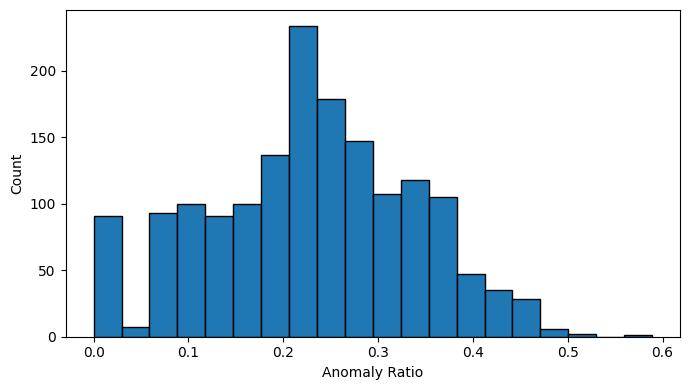

In [2]:
!pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt

target_feature = 'Jerk'  # or whatever you used earlier
metrics_df = pd.read_csv(f"metrics_summary_{target_feature}.csv")

plt.figure(figsize=(7,4))
plt.hist(metrics_df['Anomaly_Prob'].dropna(), bins=20, edgecolor='black')
plt.xlabel('Anomaly Ratio')
plt.ylabel('Count')
# plt.title('Histogram of Anomaly_Prob')
plt.tight_layout()
plt.savefig("Histogram70dyn.png", dpi=300)
plt.show()